## Expectation maximisation for a GMM in 2D

**Author:** Felipe Tobar
**Date:** 17 January, 2025

**Roadmap**: data -> init -> E-step -> M-step -> EM loop -> visuals + log-likelihood

**Statement of originality:** The conceptual structure and teaching narrative of this notebook are original.
ChatGPT 5.2 was used as a coding assistant for parts of the low-level implementation and plotting. 

### Step 0 — Setup: imports, seed, and plotting parameters


In [23]:

import numpy as np
import matplotlib.pyplot as plt

# Numerically-stable responsibilities
try:
    from scipy.special import logsumexp
except Exception:
    logsumexp = None

from matplotlib.patches import Ellipse

# fix the seed for reproducibility
SEED = 7
rng = np.random.default_rng(SEED)

# Plot default params
plt.rcParams.update({
    "figure.figsize": (7, 6),
    "axes.grid": True,
    "font.size": 12,
})

def _cov_to_ellipse(cov: np.ndarray, n_std: float = 2.0):
    """
    Convert a 2x2 covariance matrix to ellipse parameters (width, height, angle in degrees),
    where width/height correspond to the given n_std contour.
    """
    # Eigen-decomposition (cov is symmetric PSD)
    vals, vecs = np.linalg.eigh(cov)
    # Sort descending (largest axis first)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    # Ellipse angle from first eigenvector
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

    # Width/height are 2 * n_std * sqrt(eigenvalues)
    width, height = 2.0 * n_std * np.sqrt(np.maximum(vals, 0.0))
    return width, height, angle

def plot_state(X: np.ndarray,
               pis: np.ndarray | None = None,
               mus: np.ndarray | None = None,
               covs: np.ndarray | None = None,
               R: np.ndarray | None = None,
               title: str = "",
               n_std: float = 2.0):
    """
    Plot 2D data X and (optionally) the current GMM state.
    - X: (N, 2)
    - pis: (K,)
    - mus: (K, 2)
    - covs: (K, 2, 2)
    - R: (N, K) responsibilities; if provided, color by argmax responsibility.
    """
    X = np.asarray(X)
    assert X.ndim == 2 and X.shape[1] == 2, "X must be (N, 2)"

    fig, ax = plt.subplots()
    if R is None:
        ax.scatter(X[:, 0], X[:, 1], s=18, alpha=0.9)
    else:
        labels = np.argmax(R, axis=1)
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=18, alpha=0.9)

    if mus is not None and covs is not None:
        K = mus.shape[0]
        for k in range(K):
            ax.scatter(mus[k, 0], mus[k, 1], marker="x", s=120)

            width, height, angle = _cov_to_ellipse(covs[k], n_std=n_std)
            ell = Ellipse(xy=mus[k], width=width, height=height, angle=angle,
                          fill=False, linewidth=2)
            ax.add_patch(ell)

            if pis is not None:
                ax.text(mus[k, 0], mus[k, 1], f"  π={pis[k]:.2f}", va="center")

    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    plt.show()




### Step 1 — Define the GMM model and parameter representation


In [24]:
"""
Fix:
- dimensionality d = 2
- number of components K
- full covariance matrices (2x2)

Model:
z_n ~ Categorical(pi)
x_n | z_n = k ~ N(mu_k, Sigma_k)
"""

# Model hyperparameters
K = 3          # number of mixture components
d = 2          # data dimension (2D for visualization)

# Parameter container 
def make_gmm_params(pis, mus, covs):
    """
    Convenience wrapper to keep GMM parameters together and sanity-check shapes.
    """
    pis = np.asarray(pis)
    mus = np.asarray(mus)
    covs = np.asarray(covs)

    assert pis.shape == (K,)
    assert np.allclose(pis.sum(), 1.0), "Mixing weights must sum to 1"
    assert mus.shape == (K, d)
    assert covs.shape == (K, d, d)

    return {
        "pis": pis,
        "mus": mus,
        "covs": covs
    }


print(f"GMM defined with K={K} components in d={d} dimensions.")


GMM defined with K=3 components in d=2 dimensions.


### Step 2 — Generate a synthetic 2D dataset from the (known) GMM


Generated X with shape (400, 2). Component counts: [177 138  85]


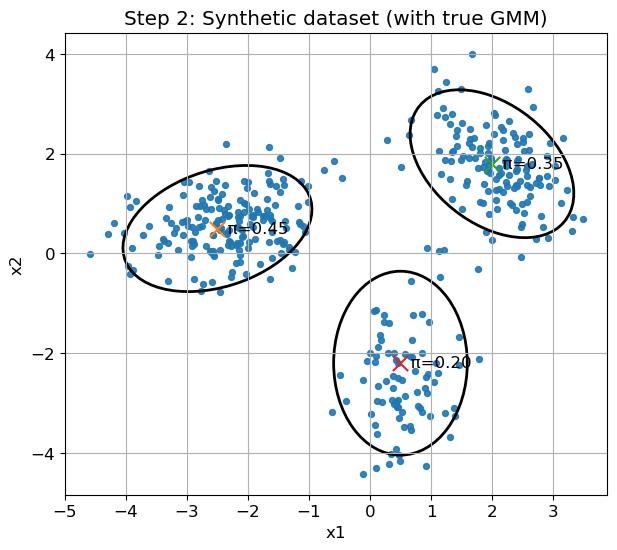

In [25]:

N = 400  # number of samples

# "Ground-truth" parameters (chosen to be visually/teaching friendly)
pis_true = np.array([0.45, 0.35, 0.20])

mus_true = np.array([
    [-2.5,  0.5],
    [ 2.0,  1.8],
    [ 0.5, -2.2],
])

covs_true = np.array([
    [[0.60,  0.15],
     [0.15,  0.40]],

    [[0.45, -0.20],
     [-0.20, 0.55]],

    [[0.30,  0.00],
     [0.00,  0.85]],
])

params_true = make_gmm_params(pis_true, mus_true, covs_true)

# Sample latent assignments z ~ Categorical(pis_true)
z_true = rng.choice(K, size=N, p=pis_true)

# Sample x | z=k ~ N(mu_k, cov_k)
X = np.empty((N, d))
for k in range(K):
    idx = (z_true == k)
    nk = idx.sum()
    if nk > 0:
        X[idx] = rng.multivariate_normal(mean=mus_true[k], cov=covs_true[k], size=nk)

print(f"Generated X with shape {X.shape}. Component counts:", np.bincount(z_true, minlength=K))

# Visualize the data and (optionally) the true generating Gaussians
plot_state(
    X,
    pis=params_true["pis"],
    mus=params_true["mus"],
    covs=params_true["covs"],
    R=None,
    title="Step 2: Synthetic dataset (with true GMM)",
    n_std=2.0
)


### Step 3 — Initialisation (good + bad) and a stable log-likelihood function


Initial log-likelihood (bad init):  -1819.58
Initial log-likelihood (good init): -1216.60


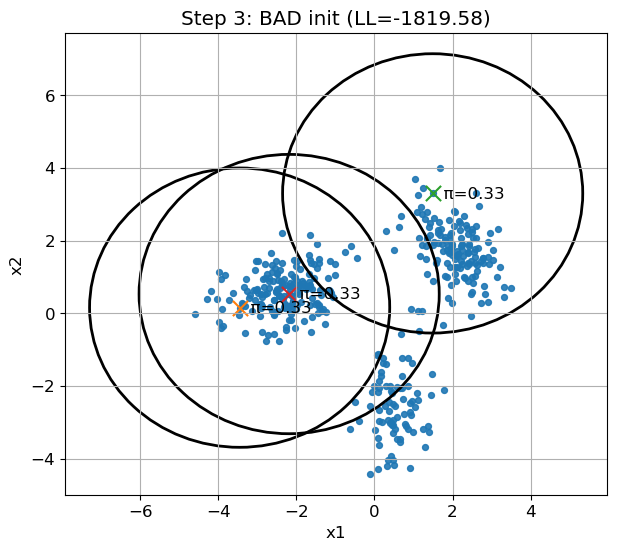

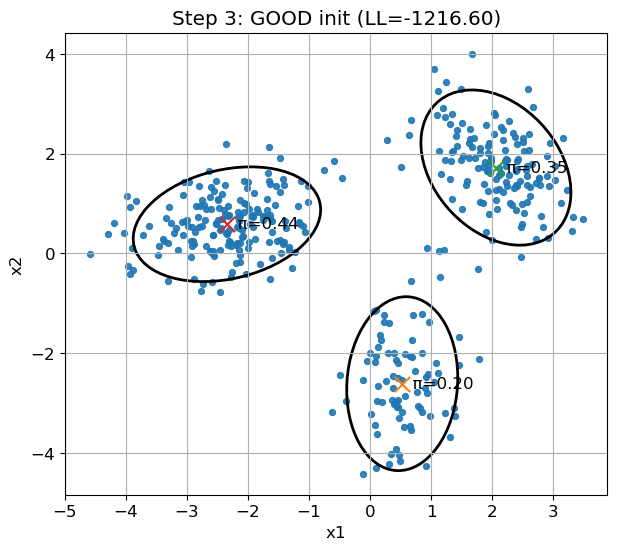

In [26]:

EPS = 1e-12          # for avoiding log(0)
COV_REG = 1e-6       # tiny diagonal regularizer to keep covariances SPD

def log_gaussian_pdf(X: np.ndarray, mu: np.ndarray, cov: np.ndarray) -> np.ndarray:
    """
    Compute log N(x | mu, cov) for each row of X.
    Returns: (N,)
    """
    X = np.asarray(X)
    mu = np.asarray(mu)
    cov = np.asarray(cov)

    # Regularize and precompute inverse + logdet
    cov = cov + COV_REG * np.eye(d)
    sign, logdet = np.linalg.slogdet(cov)
    if sign <= 0:
        raise ValueError("Covariance matrix is not SPD (even after regularisation).")

    diff = X - mu
    inv = np.linalg.inv(cov)
    quad = np.einsum("ni,ij,nj->n", diff, inv, diff)  # (x-mu)^T inv(cov) (x-mu), for each n

    return -0.5 * (d * np.log(2.0 * np.pi) + logdet + quad)

def gmm_log_likelihood(X: np.ndarray, params: dict) -> float:
    """
    Observed-data log-likelihood: sum_n log sum_k pi_k N(x_n | mu_k, cov_k)
    """
    pis, mus, covs = params["pis"], params["mus"], params["covs"]

    # Compute log pi_k + log N(x|k) -> shape (N, K)
    log_terms = np.empty((X.shape[0], K))
    for k in range(K):
        log_terms[:, k] = np.log(np.clip(pis[k], EPS, 1.0)) + log_gaussian_pdf(X, mus[k], covs[k])

    if logsumexp is None:
        # fallback (less stable): max-trick manually
        m = np.max(log_terms, axis=1, keepdims=True)
        ll = np.sum(m[:, 0] + np.log(np.sum(np.exp(log_terms - m), axis=1)))
    else:
        ll = np.sum(logsumexp(log_terms, axis=1))

    return float(ll)

def init_params_bad_random(X: np.ndarray) -> dict:
    """
    A deliberately 'poor' init: random means from data, uniform weights, shared spherical covariance.
    """
    N = X.shape[0]
    mus = X[rng.choice(N, size=K, replace=False)]
    pis = np.ones(K) / K

    # shared spherical covariance based on overall data spread
    centered = X - X.mean(axis=0)
    s2 = np.mean(np.sum(centered**2, axis=1)) / d
    covs = np.array([s2 * np.eye(d) for _ in range(K)])

    return make_gmm_params(pis, mus, covs)

def init_params_good_kmeans_like(X: np.ndarray, n_iters: int = 10) -> dict:
    """
    A lightweight k-means-ish init (no sklearn): alternating hard assign + centroid update,
    then convert to a GMM init (weights + covariances).
    """
    N = X.shape[0]
    mus = X[rng.choice(N, size=K, replace=False)].copy()

    # quick k-means loop
    for _ in range(n_iters):
        # squared distances to each center -> (N, K)
        d2 = np.sum((X[:, None, :] - mus[None, :, :])**2, axis=2)
        labels = np.argmin(d2, axis=1)
        for k in range(K):
            idx = labels == k
            if np.any(idx):
                mus[k] = X[idx].mean(axis=0)

    # weights + covariances from hard clusters
    pis = np.zeros(K)
    covs = np.zeros((K, d, d))
    for k in range(K):
        idx = labels == k
        nk = idx.sum()
        pis[k] = nk / N

        if nk >= 2:
            diff = X[idx] - mus[k]
            covs[k] = (diff.T @ diff) / nk
        else:
            covs[k] = np.cov(X.T)  # fallback if a cluster is tiny/empty

        covs[k] += COV_REG * np.eye(d)

    # If any cluster ended up empty, repair it
    for k in range(K):
        if pis[k] < EPS:
            pis[k] = 1.0 / K
            mus[k] = X[rng.integers(0, N)]
            covs[k] = np.cov(X.T) + COV_REG * np.eye(d)

    pis = pis / pis.sum()
    return make_gmm_params(pis, mus, covs)

# Create two initializations
params_bad = init_params_bad_random(X)
params_good = init_params_good_kmeans_like(X, n_iters=10)

# Compare initial log-likelihoods + visualize
ll_bad = gmm_log_likelihood(X, params_bad)
ll_good = gmm_log_likelihood(X, params_good)

print(f"Initial log-likelihood (bad init):  {ll_bad:.2f}")
print(f"Initial log-likelihood (good init): {ll_good:.2f}")

plot_state(X, **params_bad, title=f"Step 3: BAD init (LL={ll_bad:.2f})", n_std=2.0)
plot_state(X, **params_good, title=f"Step 3: GOOD init (LL={ll_good:.2f})", n_std=2.0)


### Step 4 — E-step: compute responsibilities $r_{nk} = p(z_n=k | x_n, \theta)$


E-step sanity checks:
  R_bad shape: (400, 3)  row-sums ~ (0.9999999999999998, 1.0)
  R_good shape: (400, 3) row-sums ~ (0.9999999999999998, 1.0000000000000002)


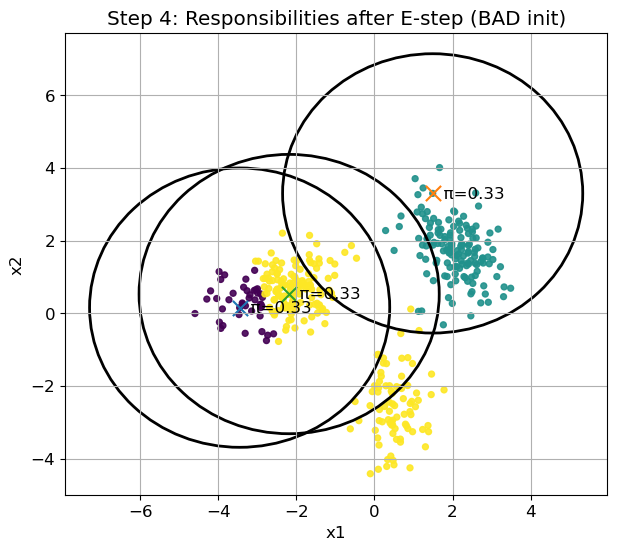

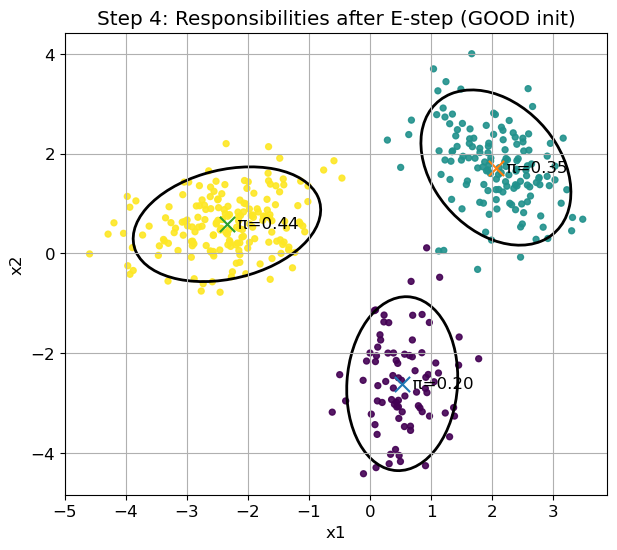

In [27]:

def e_step(X: np.ndarray, params: dict) -> np.ndarray:
    """
    Compute responsibilities R of shape (N, K).
    Uses log-domain computations for numerical stability.
    """
    pis, mus, covs = params["pis"], params["mus"], params["covs"]
    N = X.shape[0]

    # log_joint[n, k] = log pi_k + log N(x_n | mu_k, cov_k)
    log_joint = np.empty((N, K))
    for k in range(K):
        log_joint[:, k] = np.log(np.clip(pis[k], EPS, 1.0)) + log_gaussian_pdf(X, mus[k], covs[k])

    # log_norm[n] = log sum_k exp(log_joint[n,k])
    if logsumexp is None:
        m = np.max(log_joint, axis=1, keepdims=True)
        log_norm = m[:, 0] + np.log(np.sum(np.exp(log_joint - m), axis=1))
    else:
        log_norm = logsumexp(log_joint, axis=1)

    # log R = log_joint - log_norm
    log_R = log_joint - log_norm[:, None]
    R = np.exp(log_R)

    # Numerical cleanup (should already sum to 1 row-wise)
    R = np.clip(R, EPS, 1.0)
    R = R / R.sum(axis=1, keepdims=True)
    return R

# Demo: run E-step once on the two initializations and visualize responsibilities
R_bad = e_step(X, params_bad)
R_good = e_step(X, params_good)

print("E-step sanity checks:")
print("  R_bad shape:", R_bad.shape, " row-sums ~", (R_bad.sum(axis=1).min(), R_bad.sum(axis=1).max()))
print("  R_good shape:", R_good.shape, "row-sums ~", (R_good.sum(axis=1).min(), R_good.sum(axis=1).max()))

plot_state(X, **params_bad, R=R_bad, title="Step 4: Responsibilities after E-step (BAD init)", n_std=2.0)
plot_state(X, **params_good, R=R_good, title="Step 4: Responsibilities after E-step (GOOD init)", n_std=2.0)



### Step 5 — M-step: update $(\pi, \mu, \Sigma)$ given responsibilities $R$


After 1 EM iter (bad init):  LL=-1490.82 (was -1819.58)
After 1 EM iter (good init): LL=-1215.46 (was -1216.60)


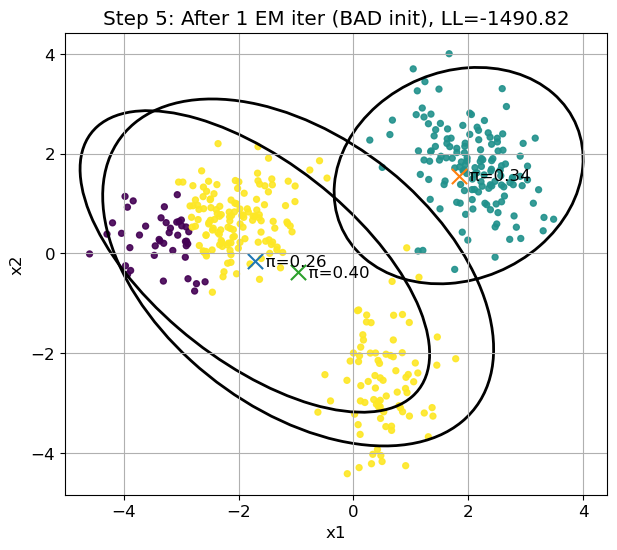

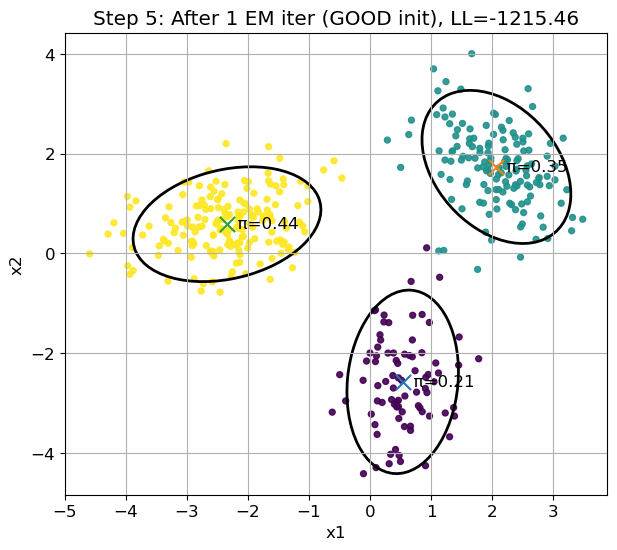

In [28]:

def m_step(X: np.ndarray, R: np.ndarray, cov_reg: float = COV_REG) -> dict:
    """
    Update GMM parameters given responsibilities R.
    Returns a new params dict {pis, mus, covs}.
    """
    X = np.asarray(X)
    R = np.asarray(R)
    N, d_ = X.shape
    assert d_ == d
    assert R.shape == (N, K)

    Nk = R.sum(axis=0)                       # (K,)
    pis = Nk / N                             # (K,)

    # Means: mu_k = (1/Nk) sum_n r_nk x_n
    mus = (R.T @ X) / np.clip(Nk[:, None], EPS, None)   # (K, d)

    # Covariances: Sigma_k = (1/Nk) sum_n r_nk (x_n-mu_k)(x_n-mu_k)^T
    covs = np.zeros((K, d, d))
    for k in range(K):
        diff = X - mus[k]                    # (N, d)
        # weighted outer products summed over n
        covs[k] = (diff.T * R[:, k]) @ diff / np.clip(Nk[k], EPS, None)
        covs[k] += cov_reg * np.eye(d)       # regularize to avoid singularities

    # Final cleanup: ensure pis sum to 1
    pis = np.clip(pis, EPS, 1.0)
    pis = pis / pis.sum()

    return make_gmm_params(pis, mus, covs)

# Demo: do one full EM update from each init (E then M), then compare LL and plots
def one_em_step(X: np.ndarray, params: dict):
    R = e_step(X, params)
    new_params = m_step(X, R)
    ll = gmm_log_likelihood(X, new_params)
    return R, new_params, ll

# BAD init -> one EM iteration
R1_bad, params1_bad, ll1_bad = one_em_step(X, params_bad)

# GOOD init -> one EM iteration
R1_good, params1_good, ll1_good = one_em_step(X, params_good)

print(f"After 1 EM iter (bad init):  LL={ll1_bad:.2f} (was {gmm_log_likelihood(X, params_bad):.2f})")
print(f"After 1 EM iter (good init): LL={ll1_good:.2f} (was {gmm_log_likelihood(X, params_good):.2f})")

plot_state(X, **params1_bad, R=R1_bad, title=f"Step 5: After 1 EM iter (BAD init), LL={ll1_bad:.2f}", n_std=2.0)
plot_state(X, **params1_good, R=R1_good, title=f"Step 5: After 1 EM iter (GOOD init), LL={ll1_good:.2f}", n_std=2.0)


### Step 6 — Run the full EM loop, store history, and visualise convergence


iter 00 | ll=-1490.822 | rel_impr= inf


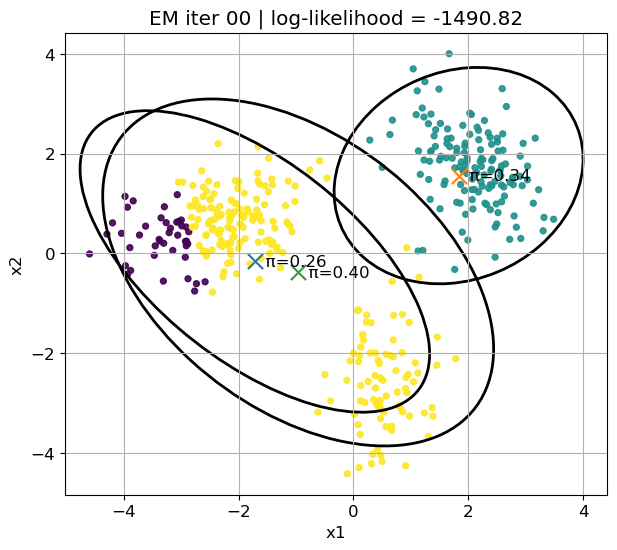

iter 01 | ll=-1398.114 | rel_impr= 6.219e-02
iter 02 | ll=-1387.007 | rel_impr= 7.944e-03


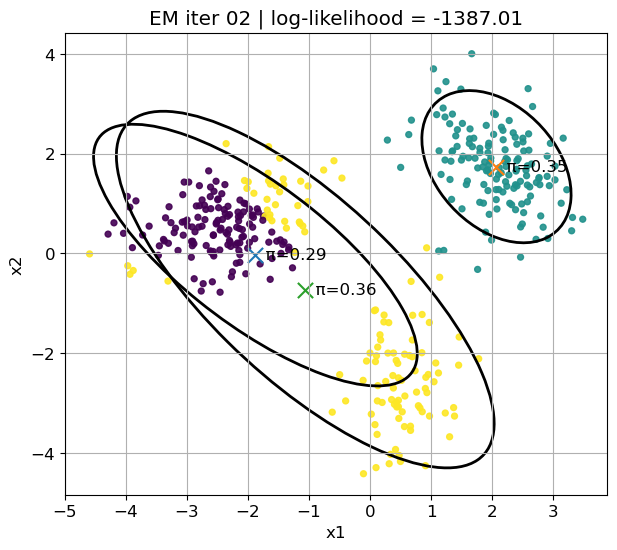

iter 03 | ll=-1377.418 | rel_impr= 6.914e-03
iter 04 | ll=-1350.962 | rel_impr= 1.921e-02


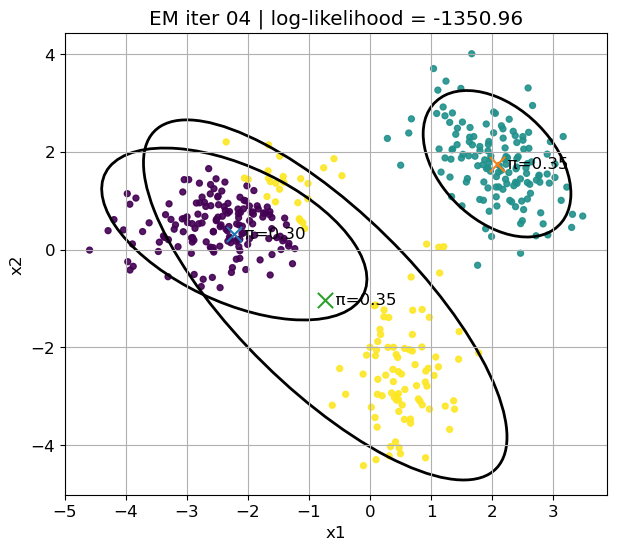

iter 05 | ll=-1299.083 | rel_impr= 3.840e-02
iter 06 | ll=-1275.830 | rel_impr= 1.790e-02


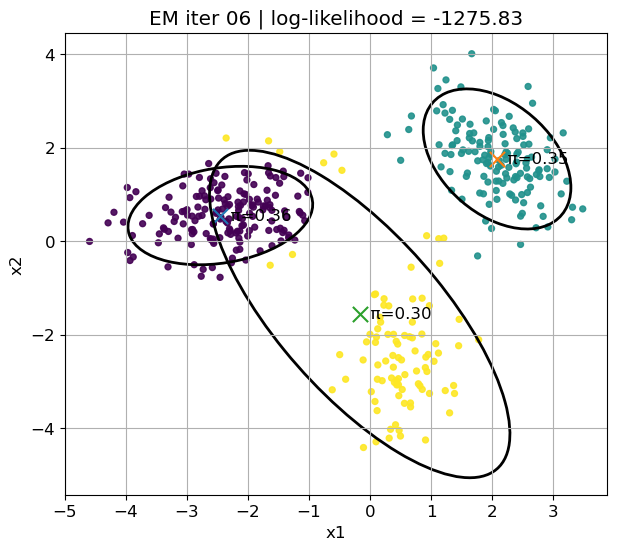

iter 07 | ll=-1265.747 | rel_impr= 7.903e-03
iter 08 | ll=-1254.069 | rel_impr= 9.226e-03


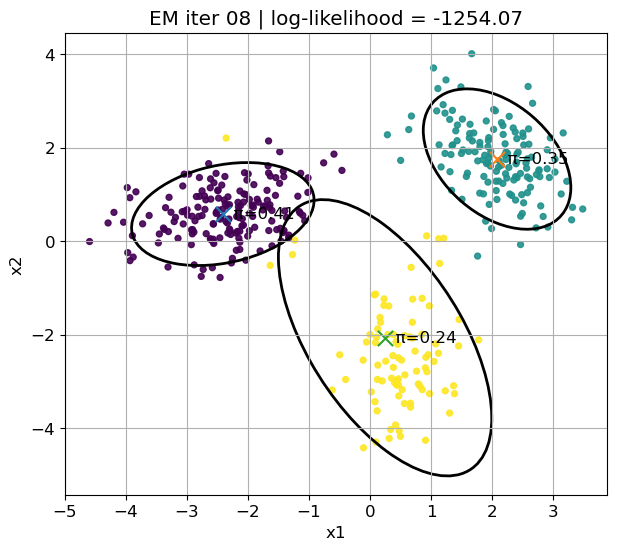

iter 09 | ll=-1235.060 | rel_impr= 1.516e-02
iter 10 | ll=-1215.640 | rel_impr= 1.572e-02


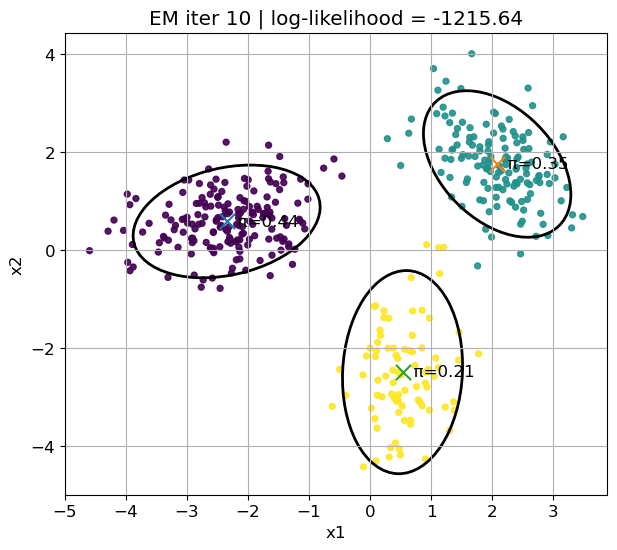

iter 11 | ll=-1214.335 | rel_impr= 1.074e-03
iter 12 | ll=-1214.322 | rel_impr= 1.079e-05


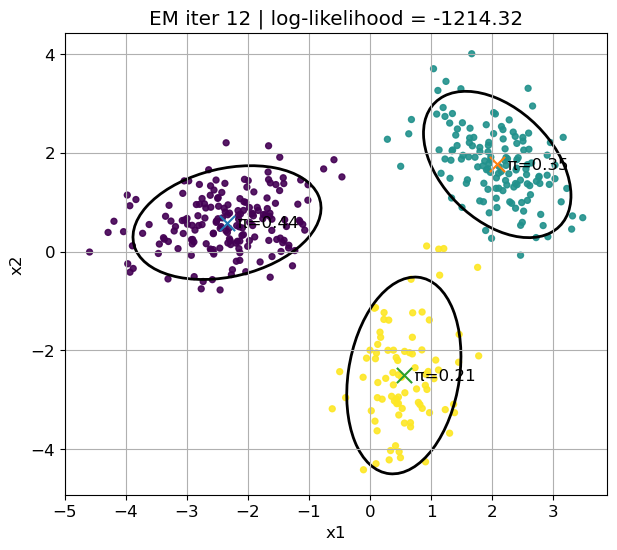

iter 13 | ll=-1214.319 | rel_impr= 2.245e-06
iter 14 | ll=-1214.318 | rel_impr= 4.460e-07


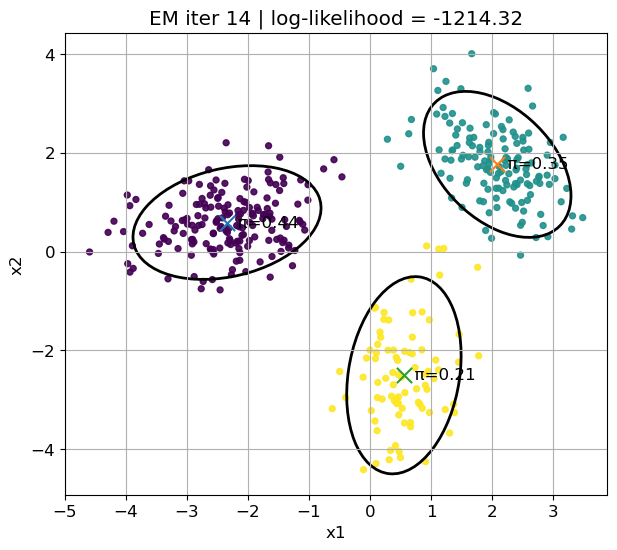

Converged: rel_impr < 1e-06 at iter 14.


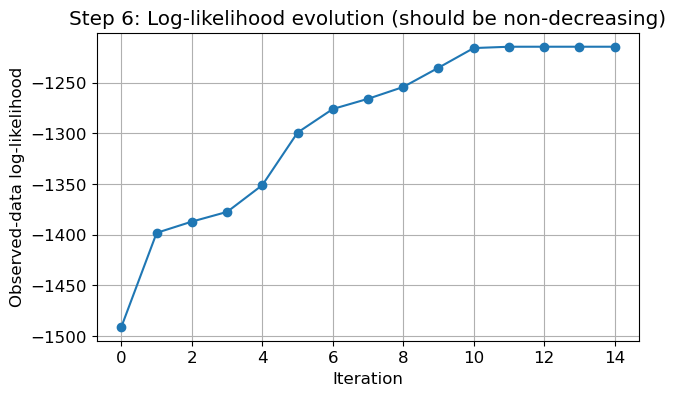

Final mixing weights: [0.443 0.346 0.211]
Final means:
 [[-2.343  0.587]
 [ 2.087  1.765]
 [ 0.556 -2.506]]


In [29]:

def run_em(
    X: np.ndarray,
    params0: dict,
    max_iters: int = 50,
    tol: float = 1e-6,
    verbose: bool = True,
    plot_every: int = 1,
):
    """
    Run EM starting from params0.
    Returns:
      params: final parameters
      history: dict with keys {"ll", "params", "R"} (lists)
    """
    params = params0
    history = {"ll": [], "params": [], "R": []}

    prev_ll = -np.inf

    for t in range(max_iters):
        # E-step
        R = e_step(X, params)

        # M-step
        params = m_step(X, R)

        # Log-likelihood
        ll = gmm_log_likelihood(X, params)

        history["ll"].append(ll)
        history["params"].append(params)
        history["R"].append(R)

        # Basic convergence check (relative improvement)
        if t > 0:
            denom = max(1.0, abs(prev_ll))
            rel_impr = (ll - prev_ll) / denom
        else:
            rel_impr = np.inf

        if verbose:
            print(f"iter {t:02d} | ll={ll: .3f} | rel_impr={rel_impr: .3e}")

        if plot_every is not None and (t % plot_every == 0 or t == max_iters - 1):
            plot_state(
                X,
                **params,
                R=R,
                title=f"EM iter {t:02d} | log-likelihood = {ll:.2f}",
                n_std=2.0
            )

        if t > 0 and rel_impr < tol:
            if verbose:
                print(f"Converged: rel_impr < {tol} at iter {t}.")
            break

        prev_ll = ll

    return params, history

# Choose which init to run
params0 = params_bad  
final_params, hist = run_em(X, params0, max_iters=40, tol=1e-6, verbose=True, plot_every=2)

# Plot log-likelihood evolution
plt.figure(figsize=(7, 4))
plt.plot(hist["ll"], marker="o")
plt.xlabel("Iteration")
plt.ylabel("Observed-data log-likelihood")
plt.title("Step 6: Log-likelihood evolution (should be non-decreasing)")
plt.grid(True)
plt.show()

print("Final mixing weights:", np.round(final_params["pis"], 3))
print("Final means:\n", np.round(final_params["mus"], 3))


### Step 7 — Final model diagnostics: learned vs true + (optional) decision regions


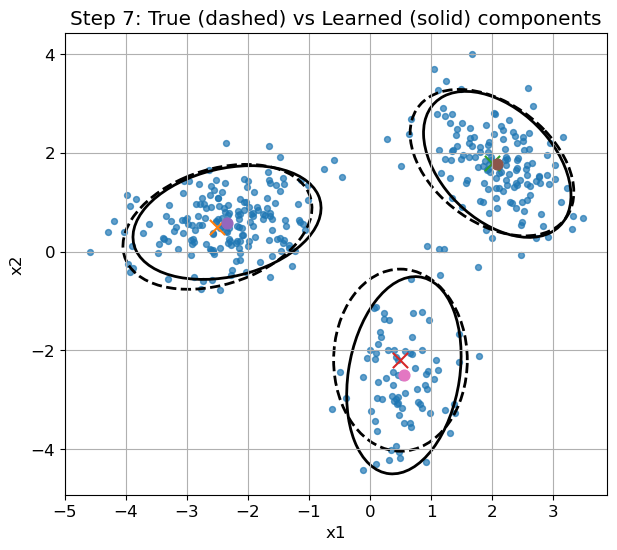

In [30]:

def match_components_by_means(mus_ref: np.ndarray, mus_est: np.ndarray) -> np.ndarray:
    """
    Greedy matching of estimated components to reference components by nearest means.
    Returns a permutation p such that est component p[k] matches ref component k.
    """
    mus_ref = np.asarray(mus_ref)
    mus_est = np.asarray(mus_est)

    remaining = set(range(K))
    perm = np.empty(K, dtype=int)

    for k in range(K):
        d2 = np.array([np.sum((mus_est[j] - mus_ref[k])**2) if j in remaining else np.inf for j in range(K)])
        j_best = int(np.argmin(d2))
        perm[k] = j_best
        remaining.remove(j_best)

    return perm

def reorder_params(params: dict, perm: np.ndarray) -> dict:
    """
    Return a reordered copy of params where new[k] = old[perm[k]].
    """
    return make_gmm_params(
        params["pis"][perm],
        params["mus"][perm],
        params["covs"][perm],
    )

def plot_true_vs_learned(X: np.ndarray, params_true: dict, params_learned: dict, title: str = ""):
    """
    Overlay true components (dashed) and learned components (solid).
    """
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.scatter(X[:, 0], X[:, 1], s=18, alpha=0.7)

    # True (dashed)
    for k in range(K):
        width, height, angle = _cov_to_ellipse(params_true["covs"][k], n_std=2.0)
        ell = Ellipse(params_true["mus"][k], width, height, angle=angle,
                      fill=False, linestyle="--", linewidth=2)
        ax.add_patch(ell)
        ax.scatter(params_true["mus"][k, 0], params_true["mus"][k, 1], marker="x", s=120)

    # Learned (solid)
    for k in range(K):
        width, height, angle = _cov_to_ellipse(params_learned["covs"][k], n_std=2.0)
        ell = Ellipse(params_learned["mus"][k], width, height, angle=angle,
                      fill=False, linestyle="-", linewidth=2)
        ax.add_patch(ell)
        ax.scatter(params_learned["mus"][k, 0], params_learned["mus"][k, 1], marker="o", s=60)

    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.grid(True)
    plt.show()

def predict_responsibilities_on_grid(params: dict, xlim, ylim, gridsize: int = 200):
    """
    Compute responsibilities on a grid for background visualization.
    Returns: xx, yy, labels (argmax responsibilities)
    """
    xs = np.linspace(xlim[0], xlim[1], gridsize)
    ys = np.linspace(ylim[0], ylim[1], gridsize)
    xx, yy = np.meshgrid(xs, ys)
    grid = np.column_stack([xx.ravel(), yy.ravel()])

    Rg = e_step(grid, params)
    labels = np.argmax(Rg, axis=1).reshape(xx.shape)
    return xx, yy, labels

# 7.1 Match learned components to true (to avoid label switching in overlay)
perm = match_components_by_means(params_true["mus"], final_params["mus"])
final_matched = reorder_params(final_params, perm)

# 7.2 Overlay plot: true (dashed) vs learned (solid)
plot_true_vs_learned(
    X,
    params_true=params_true,
    params_learned=final_matched,
    title="Step 7: True (dashed) vs Learned (solid) components"
)


### Step 8 — Wrap it into a single "demo runner", compare good vs bad init and show local optima



===== GOOD init (k-means-ish) =====
Initial LL: -1216.603922081836
iter 00 | ll=-1215.457 | rel_impr= inf


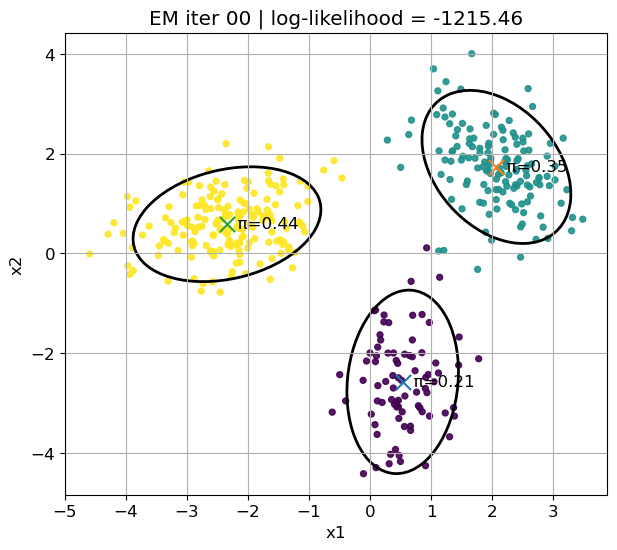

iter 01 | ll=-1214.782 | rel_impr= 5.555e-04
iter 02 | ll=-1214.464 | rel_impr= 2.619e-04
iter 03 | ll=-1214.355 | rel_impr= 8.951e-05
iter 04 | ll=-1214.326 | rel_impr= 2.368e-05
iter 05 | ll=-1214.320 | rel_impr= 5.307e-06
iter 06 | ll=-1214.318 | rel_impr= 1.085e-06
iter 07 | ll=-1214.318 | rel_impr= 2.120e-07
Converged: rel_impr < 1e-06 at iter 7.


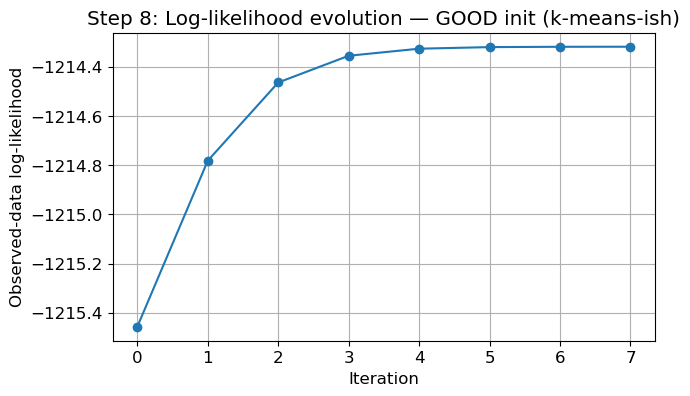

Final LL: -1214.318219363855
Final pis: [0.211 0.346 0.443]
Final mus:
 [[ 0.556 -2.505]
 [ 2.087  1.765]
 [-2.343  0.587]]

===== BAD init (random) =====
Initial LL: -1819.5753989842187
iter 00 | ll=-1490.822 | rel_impr= inf


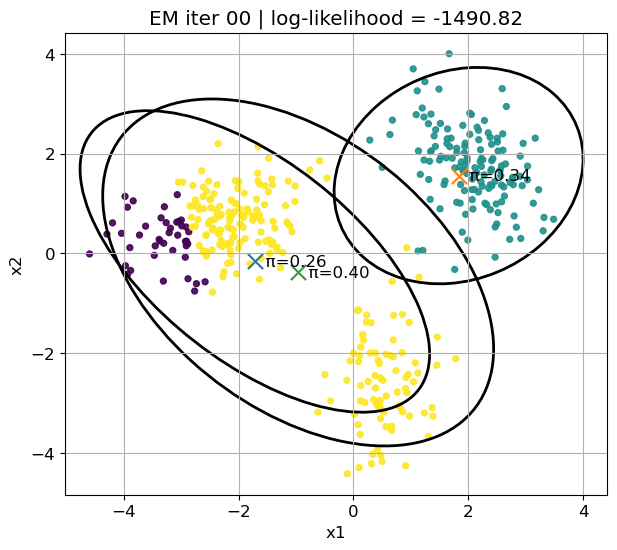

iter 01 | ll=-1398.114 | rel_impr= 6.219e-02
iter 02 | ll=-1387.007 | rel_impr= 7.944e-03
iter 03 | ll=-1377.418 | rel_impr= 6.914e-03
iter 04 | ll=-1350.962 | rel_impr= 1.921e-02
iter 05 | ll=-1299.083 | rel_impr= 3.840e-02
iter 06 | ll=-1275.830 | rel_impr= 1.790e-02
iter 07 | ll=-1265.747 | rel_impr= 7.903e-03
iter 08 | ll=-1254.069 | rel_impr= 9.226e-03
iter 09 | ll=-1235.060 | rel_impr= 1.516e-02
iter 10 | ll=-1215.640 | rel_impr= 1.572e-02
iter 11 | ll=-1214.335 | rel_impr= 1.074e-03
iter 12 | ll=-1214.322 | rel_impr= 1.079e-05
iter 13 | ll=-1214.319 | rel_impr= 2.245e-06
iter 14 | ll=-1214.318 | rel_impr= 4.460e-07
Converged: rel_impr < 1e-06 at iter 14.


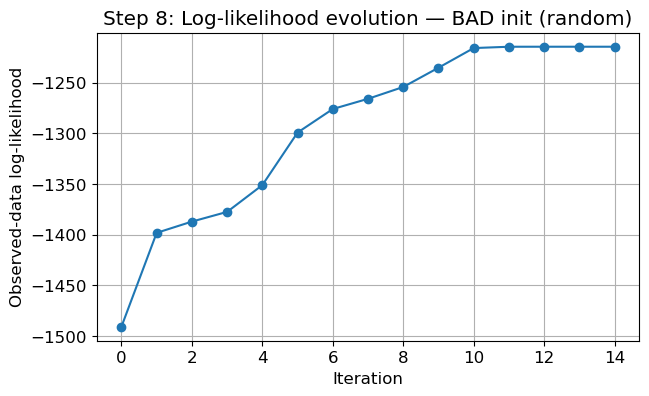

Final LL: -1214.3182875325242
Final pis: [0.443 0.346 0.211]
Final mus:
 [[-2.343  0.587]
 [ 2.087  1.765]
 [ 0.556 -2.506]]


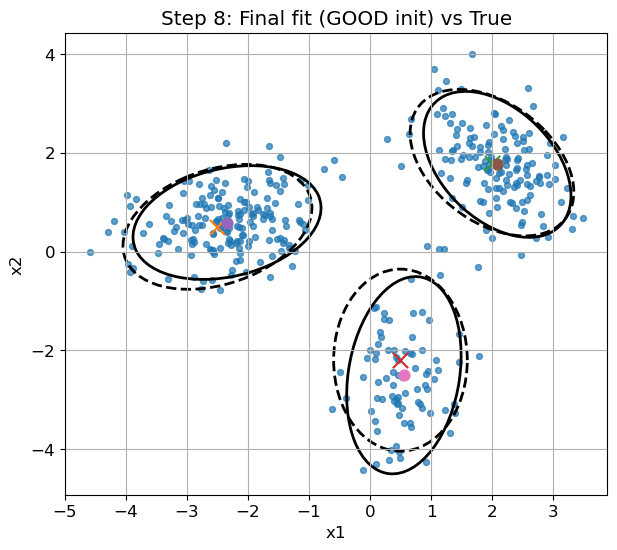

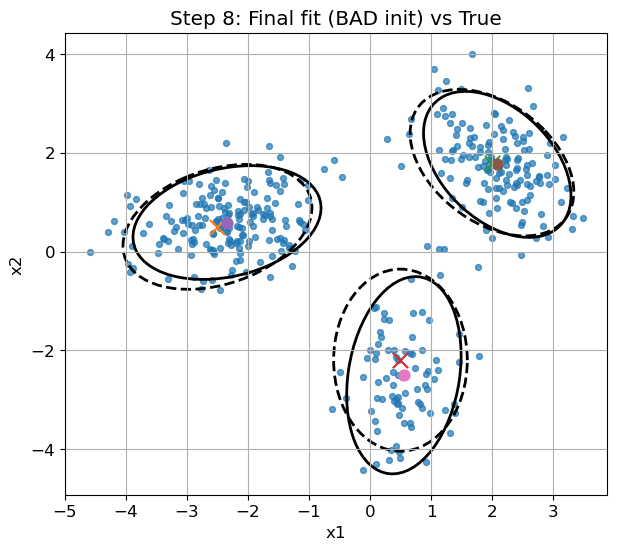

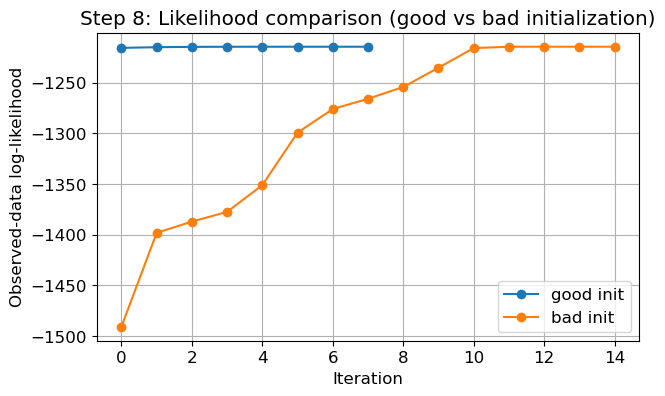

In [33]:

def demo_em_run(
    X: np.ndarray,
    params0: dict,
    name: str,
    max_iters: int = 40,
    tol: float = 1e-6,
    plot_every: int = 5,
):
    """
    Run EM and return (final_params, history). Also produces a likelihood plot.
    """
    print(f"\n===== {name} =====")
    print("Initial LL:", gmm_log_likelihood(X, params0))

    final_params, hist = run_em(
        X,
        params0,
        max_iters=max_iters,
        tol=tol,
        verbose=True,
        plot_every=plot_every,
    )

    plt.figure(figsize=(7, 4))
    plt.plot(hist["ll"], marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Observed-data log-likelihood")
    plt.title(f"Step 8: Log-likelihood evolution — {name}")
    plt.grid(True)
    plt.show()

    print("Final LL:", hist["ll"][-1])
    print("Final pis:", np.round(final_params["pis"], 3))
    print("Final mus:\n", np.round(final_params["mus"], 3))
    return final_params, hist

# Run both initializations to highlight differences
final_good, hist_good = demo_em_run(X, params_good, name="GOOD init (k-means-ish)", plot_every=9999)
final_bad,  hist_bad  = demo_em_run(X, params_bad,  name="BAD init (random)",     plot_every=999)

# Overlay final fits vs the true generating model (with mean-matching for readability)
perm_good = match_components_by_means(params_true["mus"], final_good["mus"])
final_good_m = reorder_params(final_good, perm_good)

perm_bad = match_components_by_means(params_true["mus"], final_bad["mus"])
final_bad_m = reorder_params(final_bad, perm_bad)

plot_true_vs_learned(X, params_true, final_good_m, title="Step 8: Final fit (GOOD init) vs True")
plot_true_vs_learned(X, params_true, final_bad_m,  title="Step 8: Final fit (BAD init) vs True")

# Compare likelihood trajectories on one plot (nice lecture slide)
plt.figure(figsize=(7, 4))
plt.plot(hist_good["ll"], marker="o", label="good init")
plt.plot(hist_bad["ll"], marker="o", label="bad init")
plt.xlabel("Iteration")
plt.ylabel("Observed-data log-likelihood")
plt.title("Step 8: Likelihood comparison (good vs bad initialization)")
plt.grid(True)
plt.legend()
plt.show()
